         Date     USD     JPY      GBP     CHF     AUD     CAD
0  2018-02-08  1.2252  134.31  0.87513  1.1555  1.5694  1.5402
1  2018-02-07  1.2338  134.84  0.88675  1.1610  1.5684  1.5445
2  2018-02-06  1.2329  134.97  0.88885  1.1571  1.5728  1.5488
3  2018-02-05  1.2440  136.67  0.88568  1.1599  1.5664  1.5468
4  2018-02-02  1.2492  137.22  0.87850  1.1596  1.5630  1.5387
                 0        1        2        3        4        5        6   \
2015-12-31  1.36249  1.36249  1.36249  1.36249  1.36249  1.36249  1.36249   
2016-01-01  1.35994  1.37287  1.35628  1.34585  1.35738  1.36337  1.35813   
2016-01-04  1.36562  1.36388  1.35927  1.35038  1.36927  1.36519  1.36522   
2016-01-05  1.37408  1.37058  1.35293  1.34991   1.3781  1.37639  1.37359   
2016-01-06  1.36303  1.37462  1.34803   1.3539  1.39335  1.36913  1.38224   

                 7        8        9    ...          90       91       92  \
2015-12-31  1.36249  1.36249  1.36249   ...     1.36249  1.36249  1.36249   
2016-

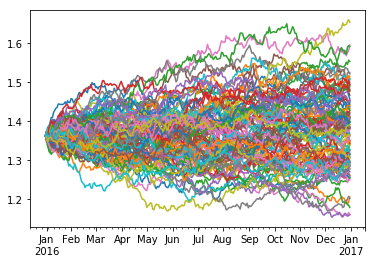

In [2]:

# coding: utf-8

# In[1]:


import os
import pandas as pd
import numpy as np
%matplotlib inline

os.chdir('/home/malek/Code/FXSim-Calib-Project/exercises/')
os.listdir()


# In[43]:


rates = pd.read_csv('eurofxref-hist.csv',usecols=['Date','USD','GBP','JPY','CHF','AUD','CAD'])
print(rates.head())
rates.Date = pd.to_datetime(rates.Date)
rates[rates.Date > '2018-01-01'].head()
rates = rates.set_index('Date')


# In[49]:


rates['EUR'] = 1
rates = rates[rates.index < '2016-01-01']
rates = rates[rates.index > '2012-12-31']
rates = rates.div(rates.GBP,axis=0)
rates = rates.drop('GBP',1)


# In[74]:


#we calculate log returns from the past 3 years
logreturns = np.log(rates.EUR) - np.log(rates.shift(-1).EUR)
#the standard deviation of our simulated log returns will be the standard deviations of the historical data
std = logreturns.std()
nsims = 100
sim_dates = pd.bdate_range('2015-12-31','2016-12-31')
import numpy as np

#we generate normal random numbers, which will be the log returns of our simulated prices.
rnds = np.random.normal(0,std,[len(sim_dates),nsims])
rnorm = pd.DataFrame(rnds,columns=range(nsims),index=sim_dates)


# In[87]:


sims = pd.DataFrame(columns = range(nsims),index = sim_dates)

#our simulated data will start with the last data point from our historical data
start_date = sims.index[0]
sims.loc[start_date] = rates.EUR[start_date]


# In[88]:


for i in range(1, len(sim_dates)):
    sims.loc[sim_dates[i]] = np.exp(rnorm.loc[sim_dates[i]])*sims.loc[sim_dates[i-1]]

print(sims.head())
get_ipython().run_line_magic('matplotlib', 'inline')
sims.plot(legend = False)

100


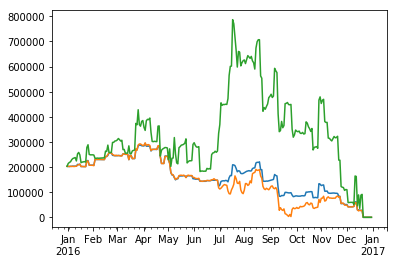

In [65]:
import pandas as pd

class FXForward: 
    def __init__(self,pay_ccy,rec_ccy,pay_amt,rec_amt,date):
        self.pay_ccy = pay_ccy
        self.rec_ccy = rec_ccy
        self.pay_amt = pay_amt
        self.rec_amt = rec_amt
        self.date = date       

        
    def __repr__(self):
        result = ''
        result += 'pay: '+ self.pay_ccy + ' ' + str(self.pay_amt) + '\n'
        result += 'rec: '+ self.rec_ccy + ' ' + str(self.rec_amt) + '\n'
        result += str(self.date) + '\n'
        return result      
        
    def price(self,exchange_rate):
        #return the value of the trade given the exchange rate on the expiry date
        #the exchange rate should be 'based' in GBP, ie 1.5 if 1.5USD = 1GBP.
        #the price of the trade is the value of what we receive minus the value of what we pay
        if self.pay_ccy == 'EUR':
            return self.rec_amt - self.pay_amt/exchange_rate
        elif self.pay_ccy == 'GBP':
            return self.rec_amt/exchange_rate - self.pay_amt
        
    def price_from_sims(self,sims):
        #takes as input the simulations that we generated yesterday (261x1000 DataFrame) and returns a 261x1000
        #DataFrame of simulated prices.
        #the price of the trade is the value of what we receive minus the value of what we pay
        sim_values = self.price(sims)
        sim_values[sim_values.index > self.date] = 0
        return sim_values
    
    
fxforward = FXForward('EUR','GBP',130,100,pd.to_datetime('2016-08-31'))
fxforward.pay_ccy
prices = fxforward.price_from_sims(sims)
#prices.plot(legend = False)


def ee(prices):
    return prices[prices>0].fillna(0).mean(axis=1)

def pfe(prices,level):
    return prices[prices>0].fillna(0).quantile(level/100.0,axis=1)

def exposure_matrix(trades,sims,nettingFlag = 1):
    #takes a list of trades and simulated FX rates, and returns the exposure matrix generated by valuing
    #the trades with those simulated values
    mtm = pd.DataFrame(0,index=sims.index,columns = sims.columns)
    for trade in trades: 
        prices = trade.price_from_sims(sims)
        if nettingFlag:
            mtm = mtm + prices
        else: 
            mtm = mtm + prices[prices>0].fillna(0)
    exposure = mtm[mtm>0].fillna(0)
    return exposure
    
def make_random_trades(num_trades):

    trades = []
    for i in range(num_trades):
        date = np.random.choice(sim_dates)
        amount = np.random.randint(1,1000)*1000
        pay = np.random.choice(['EUR','GBP'])
        rec = 'EUR' if pay == 'GBP' else 'GBP'
        rate = np.random.uniform(1.3,1.42)
        eur_amt = rate*amount
        pay_amt = eur_amt if pay == 'EUR' else amount
        rec_amt = eur_amt if rec == 'EUR' else amount
        trade = FXForward(pay_ccy =pay,rec_ccy=rec,rec_amt = rec_amt,pay_amt=pay_amt,date = date)
        trades.append(trade)
    print(len(trades))
    return trades

np.random.seed(100)
trades = make_random_trades(100)
matrix = exposure_matrix(trades,sims,1)
#matrix.plot(legend=False)
ee(matrix).plot()
pfe(matrix,50).plot()
pfe(matrix,98).plot()

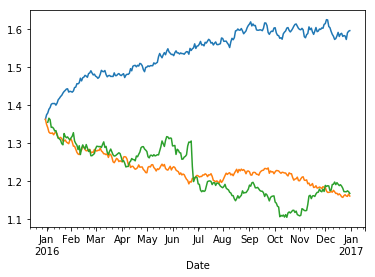

In [67]:
BTstartDate = pd.to_datetime('2016-01-01')
BTendDate = pd.to_datetime('2016-12-31')

pfe(sims,99).plot()
pfe(sims,1).plot()

ratesBT = pd.read_csv('eurofxref-hist.csv',usecols=['Date','USD','GBP','JPY','CHF','AUD','CAD'])
ratesBT['EUR'] = 1.0

ratesBT.Date = pd.to_datetime(ratesBT.Date)
ratesBT = ratesBT.set_index('Date')


ratesBT = ratesBT.div(ratesBT.GBP,axis=0)
ratesBT = ratesBT.drop('GBP',1)

ratesBT = ratesBT[ratesBT.index >= BTstartDate]
ratesBT = ratesBT[ratesBT.index <= BTendDate]

ratesBT.EUR.plot()




In [66]:
logreturns.describe()

count    765.000000
mean       0.000135
std        0.004706
min       -0.019358
25%       -0.002401
50%        0.000182
75%        0.002765
max        0.022625
Name: EUR, dtype: float64